In [7]:
import torch
import torch.nn as nn

In [8]:
# import the libraries
import torch
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
from PIL import Image
import os

# define the dataset class
class CelebADataset(Dataset):
    # initialize the object to create the list of image paths when defining the class
    def __init__(self,root_dir,transform=None):
        """
        Args:
            root_dir(string): Directory of the images.
            transform: Optional transform to be applied to an image.(Data Augmentation)
        """
        self.root_dir=root_dir
        self.transform=transform

        # get all image file paths from the directory and create a list
        """
            1. Iterate each item in the directory in the directory using the os.listdir.
            2. Check the items extension using .endswith('jpg') function.
            3. If the item is an jpg image, get the path using os.join.path and add to the list.
        """
        self.image_paths=[os.path.join(root_dir,img) for img in os.listdir(root_dir) if img.endswith('jpg')]  

    # check the length of the class(No of images in the folder)
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,idx):
        # Load image using idx value as index to the image path list which is created at the initialization
        img_path=self.image_paths[idx]
        image=Image.open(img_path).convert('RGB')

        # Apply transform if applied
        if self.transform:
            image=self.transform(image)

        return image 

In [10]:
# define the transformations we want to apply to the images
tensor_transforms=transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor()
    ]
)

# load the dataset from the directory
dataset_path='img_align_celeba'
dataset=CelebADataset(root_dir=dataset_path,transform=tensor_transforms)
train_size = int(0.8 * len(dataset)/1000)
test_size = len(dataset) - train_size
train_dataset,test_dataset = random_split(dataset,[train_size,test_size])
# create Dataloader
dataloader=DataLoader(dataset,batch_size=128,shuffle=True,num_workers=0)  # we cannot feed the entire images at once, so we feed the images as batches
# shuffle= True ensures that everytime there is different set of images for each epoch
# check the count of images loaded
print(f"Total number of images loaded: {len(dataset)}")
print(f'Length of the train and test datasets are {len(train_dataset),len(test_dataset)}')

Total number of images loaded: 202599
Length of the train and test datasets are (162, 202437)


In [11]:
train_dataset[1].shape

torch.Size([3, 39, 32])

In [12]:
"""
    Fake architecture creation for the understanding

    1. Simple weight matrices to parametrize the layers for encoder and the distribution parameters
    2. Calculate the output of encoder, which is the input for the mean and std layers, by multiplying the
    input vector by the encoder weight matrix.
    3. Get the mean and std values by multiplying the encoder layer output by the matrices corresponding to 
    the above layers
    4. Create a normal distribution using the mean and std.
"""

input_tensor=torch.tensor([3.])

w1=torch.tensor([2.],requires_grad=True) # weight matrix for encoder layer
w_mu=torch.tensor([8.],requires_grad=True) # weight matrix for mean layer
w_sd=torch.tensor([9.],requires_grad=True) # weight matrix for std layer

enc_out=input_tensor*w1 # output of encoder layer
mu=enc_out*w_mu # mean value
sd=enc_out*w_sd # std value

# z=torch.normal(mu,sd) avoid this as it is not differentiable
z=mu+sd*torch.randn(1) # reparameterization trick
z.backward() # backpropagation for all the tensoes associated with z with requires_grad=True
w1.grad # gradient for the mean layer weight


tensor([37.0599])

Define the image transformations and load the train and test dataset

Define a simple variational autoencoder model architecture

In [13]:
"""
    This can be divided as shown below or 
    1. Encoder architecture
    2. Latent space parameters(mean and log variance) architecture
    3. Decoder architecture
    4. Encoder forwarding function
    5. Reparametrization function [Can be added with encoder forwarding function.]
    6. Decoder forwarding function [To get the generated image during the inference.]
    7. Whole model's forwading function [ Include the encoder forwarding, reparametrization and decoder forwarding.]
"""
class LinearVariationalAutoEncoder(nn.Module):
    def __init__(self,latent_dim = 20):
        super().__init__()

        # encoder network
        self.encoder = nn.Sequential(
            nn.Linear(3*32*39,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32)
        )
        # mean, std layers
        self.fn_mu=nn.Linear(32,latent_dim)
        self.fn_logvar=nn.Linear(32,latent_dim)
        
        # dcoder network
        self.decoder= nn.Sequential(
            nn.Linear(latent_dim,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,32*39*3),
            nn.Sigmoid()
        )

    # get the latent vector, mean and variance
    def forward_enc(self,x):
        x=self.encoder(x)
        mu=self.fn_mu(x)
        logvar=self.fn_logvar(x)

        sigma=torch.exp(0.5*logvar)
        noise=torch.rand_like(sigma,device=sigma.device)  # generate noise with same shape as sigma
        
        z = mu + sigma*noise
        return z, mu, logvar
    
    def forward(self,x):
        batch_size,channels,height,width = x.shape
        x= x.flatten(1)   # tensor of shape [batch_size,num_channels * height * width]
        z,mu,logvar = self.forward_enc(x)

        dec = self.decoder(z)
        dec = dec.reshape(batch_size,channels,height,width) 

        return z, mu, logvar, dec
    
    # to generate image from random vector
    def forward_dec(self,z):
       return self.decoder(z)

model= LinearVariationalAutoEncoder()
model
        

LinearVariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3744, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (fn_mu): Linear(in_features=32, out_features=20, bias=True)
  (fn_logvar): Linear(in_features=32, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3744, bias=True)
    (7): Sigmoid()
  )
)

Define the Loss Function

In [14]:
def VAELoss(x,x_hat,mean,log_var,kl_weight=1,reconstruction_weight=1):
    # reconstruction loss
    pixel_mse=(x-x_hat)**2
    pixel_mse=pixel_mse.flatten(1) # size = [batch_size, num_channels * width * height]
    # mean of total sum of the mean squared errors of pixels of a batch across batches.(divide the pixel mse by the batch_size)
    reconstruction_loss = pixel_mse.sum(axis=-1).mean() # axis = -1 add across row(all the values in a batch); 0 add across the column(values of batches in the same coordinte)
    #print(f"RL {reconstruction_loss}")
    # reconstruction_loss = pixel_mse.mean()   # mean of the total mse of all the batches(divide the pixel mse by total pixels in all the batches.).

    # KL loss
    kl = (1+log_var - mean**2-torch.exp(log_var))  # kl values for each batch: shape = [4,2] (shape of mean, log_var)
    kl_per_image = -0.5*torch.sum(kl,axis=-1) # total sum across each row
    kl_loss = torch.mean(kl_per_image) # mean of the above sum
    #print(f"KL {kl_per_image}")
    return reconstruction_loss * reconstruction_weight + kl_loss * kl_weight
    

In [15]:
x=torch.randn(4,1,39,32)
x_hat=torch.randn(4,1,39,32)

mean=torch.randn(4,2)
logvar=torch.randn(4,2)

a=VAELoss(x,x_hat,mean,logvar)
print(a)

tensor(2483.1211)


Training Script

In [16]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

In [17]:

def train(model,
          kl_weight,
          train_set,
          test_set,
          batch_size,
          training_iterations,
          evaluation_iterations):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # data loaders for the train and test set
    train_loader=DataLoader(train_set,batch_size=64,shuffle=True,num_workers=2)
    test_loader = DataLoader(test_set,batch_size=64,shuffle=True,num_workers=2)

    optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

    # list for storing the losses
    train_loss = []
    evaluation_loss = []

    encoded_data_per_eval = []
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))

    train = True
    step_counter = 0
    while train:
        for images in train_loader:
            images=images.to(device)

            # calculate the training loss and other parameters
            encoded,mu,logvar,decoded = model(images)
            loss = VAELoss(images,decoded,mu,logvar,kl_weight)
            train_loss.append(loss.item())

            # backpropagation and gradient descent
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # evaluation (optinonal)
            if step_counter % evaluation_iterations == 0:
                # set the model in evaluation mode
                model.eval()

                encoded_evaluations = []
                for images in test_loader:
                    images = images.to(device)

                    # calculate loss for evaluation
                    encoded,mu,logvar,decoded = model(images)
                    loss = VAELoss(images,decoded, mu,logvar,kl_weight)

                    evaluation_loss.append(loss.item())

                # caluculate the mean losses images
                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                # add the losses of each batch to the list
                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)

                
                train_loss = []
                evaluation_loss = []

                # set the model again to the training mode after the evaluation mode
                model.train()

            step_counter+=1
            pbar.update(1)

            if step_counter >= training_iterations:
                print("Completed training !")
                train = False
                break

    print(f"Final training loss {train_losses[-1]}")
    print(f"Final evaluation loss {evaluation_losses[-1]}")

    return model, train_losses, evaluation_losses, encoded_data_per_eval


In [ ]:
kl_weights = [45]
models = []
encoded_datas = []
for kl_weight in kl_weights:
    model = LinearVariationalAutoEncoder()
    print(f"kl_weight: {kl_weight}")
    model,train_losses, evealuation_losses, encoded_data_per_eval = train(model, 
                                                                          kl_weight = kl_weight, 
                                                                          train_set = train_dataset, 
                                                                          test_set = test_dataset, 
                                                                          batch_size = 64, 
                                                                          training_iterations = 100, 
                                                                          evaluation_iterations = 20)
    encoded_datas.append(encoded_data_per_eval)
    models.append(model)

kl_weight: 45


  0%|          | 0/100 [00:00<?, ?it/s]

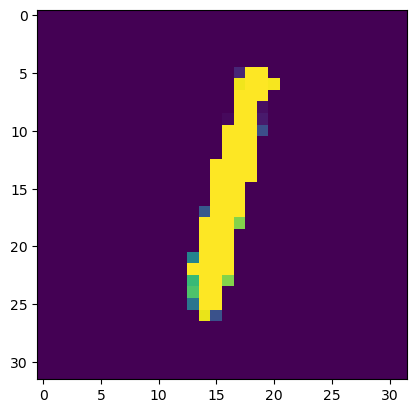

In [ ]:
vae=models[0]
z = torch.randn(20)
z=torch.tensor(z).unsqueeze(0).type(torch.float32)
with torch.no_grad():
    generated = vae.forward_dec(z)
generated = generated.cpu().reshape(32,32).numpy()

import matplotlib.pyplot as plt
plt.imshow(generated)

In [6]:
z = torch.randn(20)
z=torch.tensor(z).unsqueeze(0).type(torch.float32)
print(z.shape)

torch.Size([1, 20])


C:\Users\lenov\AppData\Local\Temp\ipykernel_5648\2266519356.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z=torch.tensor(z).unsqueeze(0).type(torch.float32)


In [17]:
import torch
import torch.nn as nn

num_patches = 196
embed_dim = 768

position_embedding = nn.Embedding(num_patches,embed_dim)
position_ids = torch.arange(num_patches).expand((4,10,-1))
position_ids.shape


torch.Size([4, 10, 196])

In [22]:
tens = torch.randn(1,14, 36)
print(tens.shape)

torch.Size([1, 14, 36])


In [23]:
pat = tens[0].detach()
print(pat.shape)

torch.Size([14, 36])
